In [3]:
import os
import cv2
import numpy as np
import math
import mediapipe as mp
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import os
import glob
import numpy as np
from tqdm.auto import tqdm


BaseOptions = mp.tasks.BaseOptions
HandLandmarker = mp.tasks.vision.HandLandmarker
HandLandmarkerOptions = mp.tasks.vision.HandLandmarkerOptions
VisionRunningMode = mp.tasks.vision.RunningMode

class HandDetector:
    def __init__(self, mode=VisionRunningMode.IMAGE, maxHands=1, detectionCon=0.5, minTrackCon=0.5):
        self.mode = mode
        self.maxHands = maxHands
        self.detectionCon = detectionCon
        self.minTrackCon = minTrackCon
        self.mpHands = mp.solutions.hands
        self.hands = self.mpHands.Hands(static_image_mode=self.mode, max_num_hands=self.maxHands,
                                        min_detection_confidence=self.detectionCon,
                                        min_tracking_confidence=self.minTrackCon)
        self.mpDraw = mp.solutions.drawing_utils
        self.tipIds = [4, 8, 12, 16, 20]
        self.fingers = []
        self.lmList = []
        
    def findHands(self, img_url, draw = True):
        img = cv2.imread(img_url)
        img_bone = np.ones((img.shape[0], img.shape[1], 3)) * 255
        
        img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        self.results = self.hands.process(img_RGB)
        all_hands = []
        h, w, c = img.shape
        if self.results.multi_hand_landmarks:
            mylmList = []
            for handType, handLms in zip(self.results.multi_handedness, self.results.multi_hand_landmarks):
                myHand = {}
                ## lmList
              
                xList = []
                yList = []
                zList = []
                for id, lm in enumerate(handLms.landmark):
                    px, py, pz = int(lm.x * w), int(lm.y * h), int(lm.z * w)
                    mylmList.append([lm.x, lm.y, lm.z])
                    xList.append(px)
                    yList.append(py)
                    zList.append(pz)
                ## bbox
                x_min, x_max = min(xList), max(xList)
                y_min, y_max = min(yList), max(yList)
                boxW, boxH = x_max - x_min, y_max - y_min
                bbox = x_min, y_min, boxW, boxH

                myHand["lmList"] = mylmList
                myHand["bbox"] = bbox
                myHand["xList"] = xList
                myHand["yList"] = yList
                myHand["zList"] = zList
                all_hands.append(myHand)
                # draw
                if draw:
                    self.mpDraw.draw_landmarks(img_bone, handLms,
                                               self.mpHands.HAND_CONNECTIONS)
            return torch.tensor(mylmList)
        return None
        
  

/home/aiotlab3/anaconda3/envs/hungvv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I use self attention in this version

In [4]:
def find_adjacency_matrix():
    mp_hands = mp.solutions.hands
    hands = mp_hands.Hands()
    adj = torch.zeros((21,21))
    for connection in mp_hands.HAND_CONNECTIONS:
        adj[connection[0],connection[1]] = 1
        adj[connection[1],connection[0]] = 1
    return adj 

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

class GraphConvolution(nn.Module):
	def __init__(self, input_dim, output_dim, num_vetex, act=F.relu, dropout=0.5, bias=True):
		super(GraphConvolution, self).__init__()

		self.alpha = 1.

		self.act = act
		self.dropout = nn.Dropout(dropout)
		self.weight = nn.Parameter(torch.randn(input_dim, output_dim)).to(device)
		self.weight1 = nn.Parameter(torch.randn(input_dim, input_dim)).to(device)
		if bias:
			self.bias = nn.Parameter(torch.randn(output_dim)).to(device)
		else:
			self.bias = None

		for w in [self.weight]:
			nn.init.xavier_normal_(w)

	def normalize(self, m):
		rowsum = torch.sum(m, 0)
		r_inv = torch.pow(rowsum, -0.5)
		r_mat_inv = torch.diag(r_inv).float()

		m_norm = torch.mm(r_mat_inv, m)
		m_norm = torch.mm(m_norm, r_mat_inv)

		return m_norm

	def caculate_attention_matrix(self,x,adj):
		score = torch.einsum("abd,dk->abk",x,self.weight1).to(device)
		score = torch.einsum("abd,acd->abc",score,x).to(device)
		score = score*( (torch.ones(adj.shape) - adj).to(device) )
		return torch.softmax(score,dim=1).to(device)
		

	def forward(self, adj, x):

		x = self.dropout(x)
		score = self.caculate_attention_matrix(x,adj)
		# K-ordered Chebyshev polynomial
		adj_norm = self.normalize(adj)
		sqr_norm = self.normalize(torch.mm(adj,adj))
		m_norm = (self.alpha*adj_norm + (1.-self.alpha)*sqr_norm).to(device)

		score = m_norm + score*0.5
		x_tmp = torch.einsum('abd,de->abe', x, self.weight)
		
		x_out = torch.einsum('aij,aid->ajd', score, x_tmp)
		if self.bias is not None:
			x_out += self.bias

		x_out = self.act(x_out)
		
		return x_out
		
		

class StandConvolution(nn.Module):
	def __init__(self, dims, num_classes, dropout):
		super(StandConvolution, self).__init__()

		self.dropout = nn.Dropout(dropout)
		self.conv = nn.Sequential(
                        nn.Conv1d(dims[0], dims[1], kernel_size=3, stride=1,padding = 1),
                        nn.InstanceNorm1d(dims[1]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[1], dims[2], kernel_size=3, stride=1,padding = 1),
                        nn.InstanceNorm1d(dims[2]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2),
                        nn.Conv1d(dims[2], dims[3], kernel_size=3, stride=1,padding = 1),
                        nn.InstanceNorm1d(dims[3]),
                        nn.ReLU(inplace=True),
                        
                        #nn.AvgPool2d(3, stride=2)
                        ).to(device)
		self.fc = nn.Linear(64*21, num_classes).to(device)

	def forward(self, x):
		
		x = self.dropout(x.permute(0,2,1))
		x_tmp = self.conv(x)
		x_out = self.fc(x_tmp.view(x.size(0), -1))

		return x_out


In [6]:
class GGCN(nn.Module):
	def __init__(self, adj, num_classes, gc_dims, sc_dims, dropout=0.5):
		super(GGCN, self).__init__()

		terminal_cnt = 5
		actor_cnt = 1
		self.adj = adj + torch.eye(adj.size(0)).to(adj).detach()
	
		self.gcl = GraphConvolution(gc_dims[0], gc_dims[1], 21, dropout=dropout)
		self.conv= StandConvolution(sc_dims, num_classes, dropout=dropout)

	def forward(self, x):
		
		multi_conv = self.gcl(self.adj, x) # 1,21,3
		logit = self.conv(multi_conv)
		return logit

In [7]:
handDetector = HandDetector()
node = handDetector.findHands("./data/image/subsampleHAR/dislike/001c6f56-85cf-4e45-bfc1-1af53c0e501b.jpg")


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [8]:
class HandSignData(Dataset):
    def __init__(self,img_dir,img_labels,transform = None):
        self.img_dir = img_dir
        self.img_labels = img_labels
        self.transform = transform
    def __len__(self):
        return len(self.img_dir)
    def __getitem__(self, idx):
        node = handDetector.findHands(self.img_dir[idx])
        cnt = 0
        while node == None:
            node = handDetector.findHands(self.img_dir[cnt])
            cnt +=1
        
        node = torch.tensor(node)
        # print(self.img_dir[idx])
        return (node,self.img_labels[idx])
    
    
def load_data(ROOT,train_size,valid_size,test_size,n = 5):
    folder_name = os.listdir(ROOT)
    labels = {}
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []
    # read and save to X,y
    for i in range(len(folder_name)):
        labels[folder_name[i]] = i
        file_list = glob.glob(os.path.join(ROOT,folder_name[i])+"/*")
        subset_len = len(file_list)//n
        #shuffle
        np.random.shuffle(file_list)
        
        X_train.extend(file_list[:subset_len*(n-2)])
        X_val.extend(file_list[subset_len*(n-2):subset_len*(n-1)])
        X_test.extend(file_list[subset_len*(n-1):])
        
        y_train.extend(np.full(len(file_list[:subset_len*(n-2)]),i))
        y_val.extend(np.full(len(file_list[subset_len*(n-2):subset_len*(n-1)]),i))
        y_test.extend(np.full(len(file_list[subset_len*(n-1):]),i))
    
   
    train_loader = DataLoader(HandSignData(X_train,y_train),batch_size = train_size,drop_last = False)
    valid_loader = DataLoader(HandSignData(X_val,y_val),batch_size = valid_size,drop_last = False)
    test_loader = DataLoader(HandSignData(X_test,y_test),batch_size = test_size,drop_last = False)  
   
    return train_loader,valid_loader,test_loader

In [9]:
train_loader,valid_loader,test_loader = load_data("./data/image/subsampleHAR",128,64,64)
model = GGCN(find_adjacency_matrix(),18,[3,9],[9, 16, 32, 64],0).to(device)


In [12]:
def train(train_loader,model,criterion,optimizer,device):
    running_loss = 0
    model.train()
   
    for images,labels in tqdm(train_loader):
        
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        
    
    epoch_loss = running_loss / (len(train_loader))
    return model,epoch_loss,optimizer

def validate(valid_loader,model,criterion,device):
    model.eval()
    running_loss = 0
   
    
    for images,labels in tqdm(valid_loader):
       
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        outputs = model(images)
        loss = criterion(outputs,labels)
        running_loss += loss.item()

    epoch_loss = running_loss / (len(valid_loader))
    return model,epoch_loss

def get_accuracy(model,data_loader,device):
    correct = 0
    total = 0
    
    with torch.no_grad():
        model.eval()
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            predicted = torch.argmax(outputs,1)
            total += labels.shape[0]
            correct += (predicted == labels).sum().item()
    return correct*100/total

def plot_losses(train_losses,valid_losses):
    train_losses = np.array(train_losses)
    valid_losses = np.array(valid_losses)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_losses, color="blue", label="train_loss")
    ax1.plot(valid_losses, color="red", label="valid_loss")
    ax1.set(title="Loss over epochs",
            xlabel="Epoch",
            ylabel="Loss")
    ax1.legend()
    
def plot_accuracy(train_acc,valid_acc):
    train_acc = np.array(train_acc)
    valid_acc = np.array(valid_acc)
    
    fig, ax1 = plt.subplots(1, 1)
    ax1.plot(train_acc, color="blue", label="train_acc")
    ax1.plot(valid_acc, color="red", label="loss_acc")
    ax1.set(title="Accuracy over epochs",
            xlabel="Epoch",
            ylabel="Accuracy")
    ax1.legend()
    

In [14]:

device = 'cuda:0'
train_loader,valid_loader,test_loader = load_data("./data/image/subsampleHAR",128,128,128)
model = GGCN(find_adjacency_matrix(),18,[3,9],[9, 16, 32, 64],0).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 50
train_losses = []
valid_losses = []
train_accuracy = []
val_accuracy = []
for epoch in range(epochs):
    # training
    model,train_loss,optimizer = train(train_loader,model,criterion,optimizer,device)
    
    # validation
    with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
    train_acc = get_accuracy(model,train_loader,device)
    val_acc = get_accuracy(model,valid_loader,device)
    print("Epoch {} --- Train loss = {} --- Valid loss = {} -- Train set accuracy = {} % Valid set Accuracy = {} %".format
          (epoch+1,train_loss,valid_loss,train_acc,val_acc))
    # save loss value
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    #save accuracy
    train_accuracy.append(train_acc)
    val_accuracy.append(val_acc)

  0%|          | 0/9 [00:00<?, ?it/s]

/tmp/ipykernel_144295/3279650794.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  node = torch.tensor(node)
100%|██████████| 3/3 [00:35<00:00, 11.81s/it]


Epoch 1 --- Train loss = 4.190168513192071 --- Valid loss = 3.201916217803955 -- Train set accuracy = 11.699164345403899 % Valid set Accuracy = 9.470752089136491 %


100%|██████████| 3/3 [00:34<00:00, 11.65s/it]


Epoch 2 --- Train loss = 2.871625237994724 --- Valid loss = 2.855815569559733 -- Train set accuracy = 9.842154131847725 % Valid set Accuracy = 9.749303621169917 %


100%|██████████| 3/3 [00:34<00:00, 11.62s/it]


Epoch 3 --- Train loss = 2.7885931862725153 --- Valid loss = 2.789914925893148 -- Train set accuracy = 5.8495821727019495 % Valid set Accuracy = 5.571030640668524 %


100%|██████████| 3/3 [00:34<00:00, 11.64s/it]


Epoch 4 --- Train loss = 2.8292976882722645 --- Valid loss = 2.656076510747274 -- Train set accuracy = 7.520891364902507 % Valid set Accuracy = 6.963788300835654 %


100%|██████████| 3/3 [00:35<00:00, 11.72s/it]


Epoch 5 --- Train loss = 2.697111209233602 --- Valid loss = 2.501605192820231 -- Train set accuracy = 27.948003714020427 % Valid set Accuracy = 24.79108635097493 %


100%|██████████| 3/3 [00:35<00:00, 11.72s/it]


Epoch 6 --- Train loss = 2.499053637186686 --- Valid loss = 2.3480445543924966 -- Train set accuracy = 37.79015784586815 % Valid set Accuracy = 33.147632311977716 %


100%|██████████| 3/3 [00:35<00:00, 11.70s/it]


Epoch 7 --- Train loss = 2.2957293457455106 --- Valid loss = 2.180894056955973 -- Train set accuracy = 44.84679665738162 % Valid set Accuracy = 40.66852367688022 %


100%|██████████| 3/3 [00:35<00:00, 11.70s/it]


Epoch 8 --- Train loss = 2.1204879416359796 --- Valid loss = 2.0200604597727456 -- Train set accuracy = 48.18941504178273 % Valid set Accuracy = 47.353760445682454 %


100%|██████████| 3/3 [00:34<00:00, 11.53s/it]


Epoch 9 --- Train loss = 1.9577700429492526 --- Valid loss = 1.8846697012583415 -- Train set accuracy = 55.06035283194058 % Valid set Accuracy = 52.646239554317546 %


100%|██████████| 3/3 [00:34<00:00, 11.53s/it]


Epoch 10 --- Train loss = 1.8011399375067816 --- Valid loss = 1.7757317225138347 -- Train set accuracy = 58.681522748375116 % Valid set Accuracy = 54.03899721448468 %


100%|██████████| 3/3 [00:34<00:00, 11.45s/it]


Epoch 11 --- Train loss = 1.6613669130537245 --- Valid loss = 1.6887977123260498 -- Train set accuracy = 61.46703806870938 % Valid set Accuracy = 56.54596100278552 %


100%|██████████| 3/3 [00:36<00:00, 12.14s/it]


Epoch 12 --- Train loss = 1.5508631997638278 --- Valid loss = 1.6140926678975422 -- Train set accuracy = 64.06685236768803 % Valid set Accuracy = 58.77437325905292 %


100%|██████████| 3/3 [00:34<00:00, 11.57s/it]


Epoch 13 --- Train loss = 1.453713509771559 --- Valid loss = 1.5597774982452393 -- Train set accuracy = 65.9238625812442 % Valid set Accuracy = 59.88857938718663 %


100%|██████████| 3/3 [00:35<00:00, 11.71s/it]


Epoch 14 --- Train loss = 1.3759374221165974 --- Valid loss = 1.5191094875335693 -- Train set accuracy = 67.22376973073352 % Valid set Accuracy = 61.559888579387184 %


100%|██████████| 3/3 [00:33<00:00, 11.33s/it]


Epoch 15 --- Train loss = 1.3127790424558852 --- Valid loss = 1.4788309733072917 -- Train set accuracy = 68.43082636954503 % Valid set Accuracy = 62.39554317548747 %


100%|██████████| 3/3 [00:34<00:00, 11.36s/it]


Epoch 16 --- Train loss = 1.2562377055486043 --- Valid loss = 1.451457182566325 -- Train set accuracy = 69.45218198700093 % Valid set Accuracy = 64.9025069637883 %


100%|██████████| 3/3 [00:34<00:00, 11.41s/it]


Epoch 17 --- Train loss = 1.2071411742104425 --- Valid loss = 1.4309553305308025 -- Train set accuracy = 70.28783658310121 % Valid set Accuracy = 64.34540389972145 %


100%|██████████| 3/3 [00:34<00:00, 11.44s/it]


Epoch 18 --- Train loss = 1.1750164031982422 --- Valid loss = 1.4113444089889526 -- Train set accuracy = 71.12349117920148 % Valid set Accuracy = 65.18105849582173 %


100%|██████████| 3/3 [00:34<00:00, 11.38s/it]


Epoch 19 --- Train loss = 1.1286775138643053 --- Valid loss = 1.3975953658421834 -- Train set accuracy = 70.93779015784587 % Valid set Accuracy = 65.18105849582173 %


100%|██████████| 3/3 [00:35<00:00, 11.72s/it]


Epoch 20 --- Train loss = 1.1012599799368117 --- Valid loss = 1.3874351183573406 -- Train set accuracy = 71.3091922005571 % Valid set Accuracy = 65.18105849582173 %


100%|██████████| 3/3 [00:35<00:00, 11.72s/it]


Epoch 21 --- Train loss = 1.0723603434032865 --- Valid loss = 1.3739269574483235 -- Train set accuracy = 72.14484679665738 % Valid set Accuracy = 65.73816155988858 %


100%|██████████| 3/3 [00:35<00:00, 11.80s/it]


Epoch 22 --- Train loss = 1.0453834997283087 --- Valid loss = 1.369459629058838 -- Train set accuracy = 72.60909935004642 % Valid set Accuracy = 65.73816155988858 %


100%|██████████| 3/3 [00:35<00:00, 11.69s/it]


Epoch 23 --- Train loss = 1.022765530480279 --- Valid loss = 1.3623360792795818 -- Train set accuracy = 73.3519034354689 % Valid set Accuracy = 65.73816155988858 %


 33%|███▎      | 3/9 [00:43<01:26, 14.47s/it]


KeyboardInterrupt: 

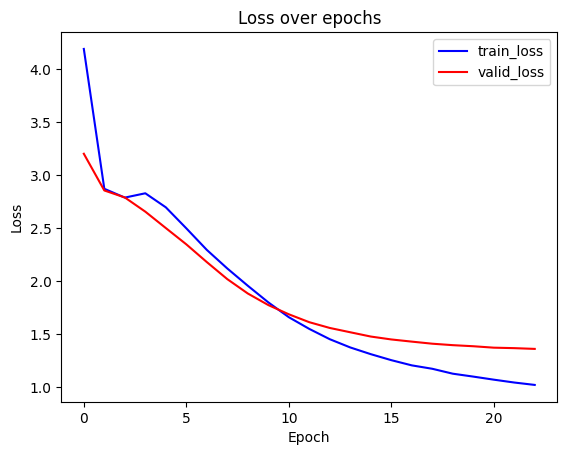

In [15]:
plot_losses(train_losses,valid_losses)

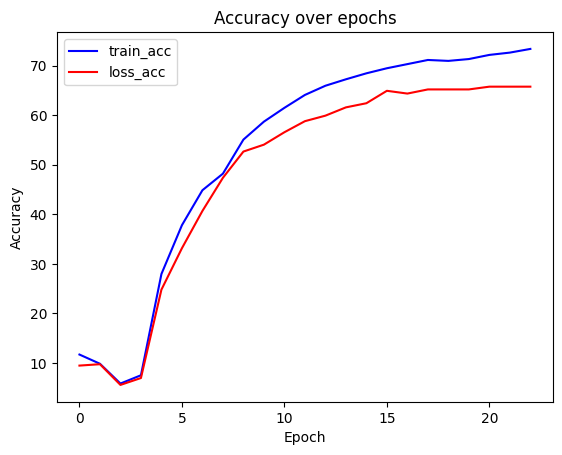

In [16]:
plot_accuracy(train_accuracy,val_accuracy)